# Apnea detection with ECG

We detect apnea by applying 1D CNN to a single lead ECG

WORK IN PROGRESS. SEE pervious version for a working version!

In [3]:
pip install wfdb

Note: you may need to restart the kernel to use updated packages.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import wfdb
import matplotlib.pyplot as plt

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# Load data

In [5]:
# get the list of files to be processed
ecgs_df = pd.read_csv("/kaggle/input/the-apnea-ecg-database-v100/apnea-ecg/1.0.0/list", header=None, names=['id'])
# add filepaths so we can retrieve the files later on
ecgs_df['filepath'] = ecgs_df['id'].apply(lambda x: str("/kaggle/input/the-apnea-ecg-database-v100/apnea-ecg/1.0.0/" + x) )
# divide the dataset into train and test dataset as per instrucctions in the data set
ecgs_df['dataset'] = ecgs_df['id'].apply(lambda x: "test" if 'x' in x else "train")

In [6]:
# display the first 5 entries
ecgs_df.head()

,id,filepath,dataset
0,a01,/kaggle/input/the-apnea-ecg-database-v100/apne...,train
1,a02,/kaggle/input/the-apnea-ecg-database-v100/apne...,train
2,a03,/kaggle/input/the-apnea-ecg-database-v100/apne...,train
3,a04,/kaggle/input/the-apnea-ecg-database-v100/apne...,train
4,a05,/kaggle/input/the-apnea-ecg-database-v100/apne...,train


In [7]:
# display number of training and testing samples
freq = ecgs_df['dataset'].value_counts()
print(freq)

dataset
train    35
test     35
Name: count, dtype: int64


In [8]:
import numpy as np
import scipy.signal  as sgn

In [9]:
def load_ecg(file):
    # load the ecg
    
    # load the ecg
    record = wfdb.rdrecord(file)
    
    # load the annotation
    annotation = wfdb.rdann(file, extension="apn")
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 100
    assert record.fs == 100, 'sample freq is not 100'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample 

In [10]:
def build_XY(p_signal, df_ann, num_cols, abnormal, num_sec, fs):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    
    return X, Y, sym

In [11]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        
        X, Y, sym = build_XY(p_signal, df_ann, num_cols, abnormal, num_sec, fs)
        
        sym_all = sym_all +sym
        
        max_rows.append(X.shape[0])
        
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

    return X_all, Y_all, sym_all


In [12]:
abnormal = ['A']

In [13]:
pts = ecgs_df[ecgs_df['dataset']=='train']

In [14]:
x_train, y_train, sym_all = make_dataset(pts['filepath'], num_sec=15, fs=100, abnormal=abnormal)

In [15]:
pts_text = ecgs_df[ecgs_df['dataset']=='test']

In [16]:
x_test, y_test, sym_all_test = make_dataset(pts_text['filepath'], num_sec=15, fs=100, abnormal=abnormal)

In [20]:
# Define function to plot some images
import matplotlib.pyplot as plt

def plot_ecgs(ecg, true_labels, class_names, start = 0 ):
    plt.figure(figsize=[12, 18])
    rows = 8
    columns = 2
    fig, ax = plt.subplots(rows, columns, figsize=(15, 15))
    index = start
    for i in range(rows):
        for j in range(columns):
            ax[i, j].plot(ecg[index])
            index = index+1
            #ax[i, j].set_ylim(ecg[i].min()-0.05,ecg[i].max()+0.05)
            ax[i, j].set_xlabel('time index')
            ax[i, j].set_ylabel('ECG signal')
            ax[i, j].set_title(class_names[int(true_labels[index])])
    
    plt.tight_layout()

/tmp/ipykernel_30/1595943881.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax[i, j].set_title(class_names[int(true_labels[index])])


<Figure size 1200x1800 with 0 Axes>

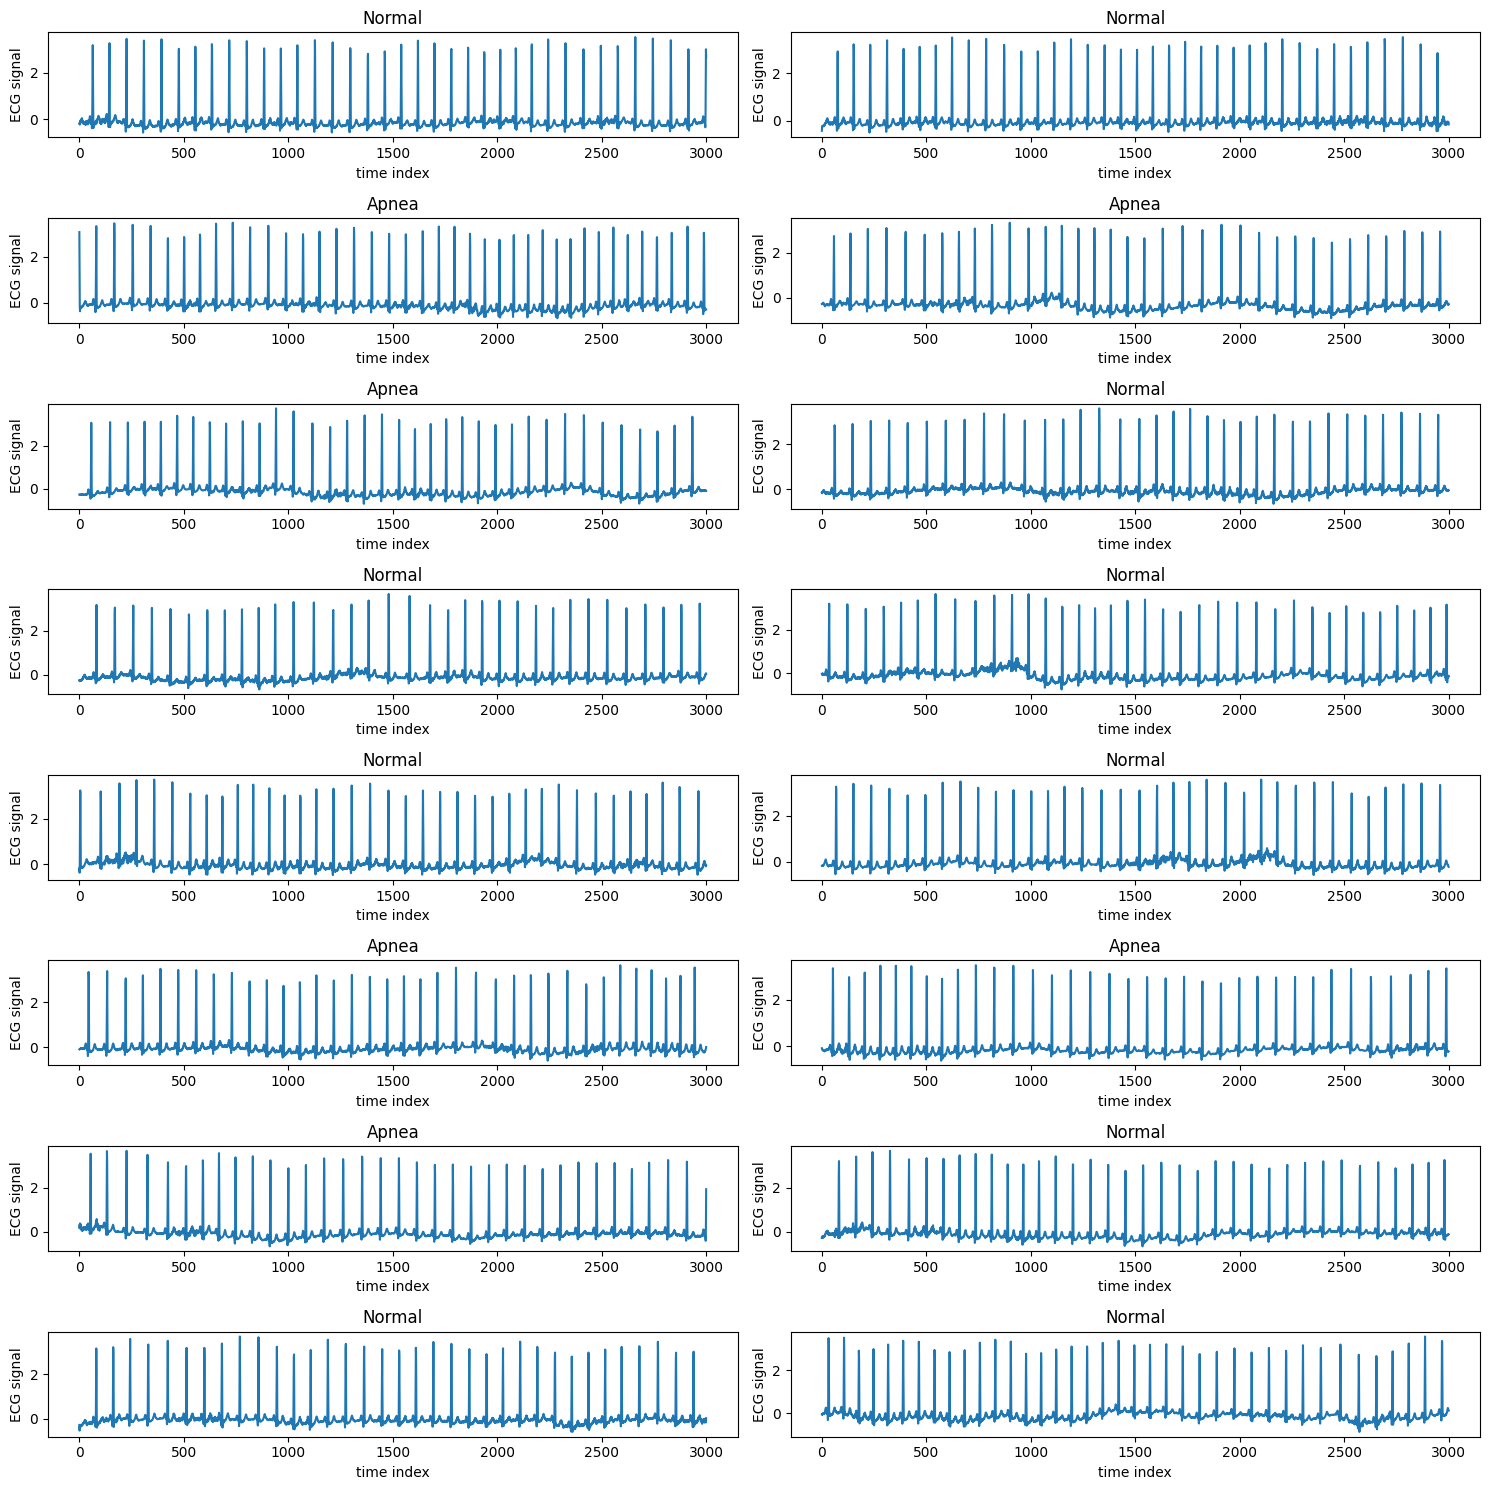

In [21]:
plot_ecgs(x_test, y_test, class_names = ['Normal','Apnea'], start=400)

https://towardsdatascience.com/detecting-heart-arrhythmias-with-deep-learning-in-keras-with-dense-cnn-and-lstm-add337d9e41f

https://physionet.org/files/apnea-ecg/1.0.0/annotations.html

In each of these files, the first annotation is placed at 0 seconds and is associated with the following one-minute interval (i.e., 0-59.99 seconds elapsed time from the beginning of the record), the second annotation is placed at 60 seconds and is associated with the next one-minute interval (60-119.99 seconds), etc. Each "A" annotation indicates that apnea was in progress at the beginning of the associated minute; each "N" annotation indicates that apnea was not in progress at the beginning of the associated minute. The diagram below may help to clarify this:

|       |       |       |       |       |       |       |       |
        ****************              ********     ********
N       A       A       N       N       A       N       A       N


In this diagram, elapsed time is represented by distance from the left edge. The '*'s mark apneic periods, the '|'s mark the times of the .apn annotations (0, 60, 120, ... seconds), and the "N"s and "A"s are the "no apnea" and "apnea" annotations.

In [22]:
values, counts = np.unique(sym_all, return_counts=True)

In [23]:
values, counts

(array(['A', 'N'], dtype='<U1'), array([ 6513, 10490]))

In [24]:
values, counts = np.unique(sym_all_test, return_counts=True)

In [25]:
values, counts

(array(['A', 'N'], dtype='<U1'), array([ 6547, 10681]))

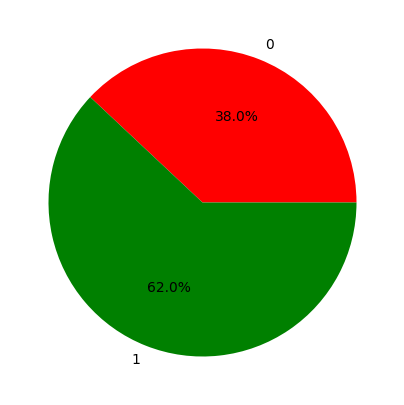

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.pie(counts, labels=['0','1'], colors=['red','green'], autopct='%1.1f%%')
plt.show()

In [27]:
from sklearn.model_selection import train_test_split

#x_train, x_test, y_train, y_test = train_test_split(X_all, Y_all, train_size = 0.8)

In [28]:
values, counts = np.unique(y_test, return_counts=True)

In [29]:
values, counts

(array([0., 1.]), array([10681,  6547]))

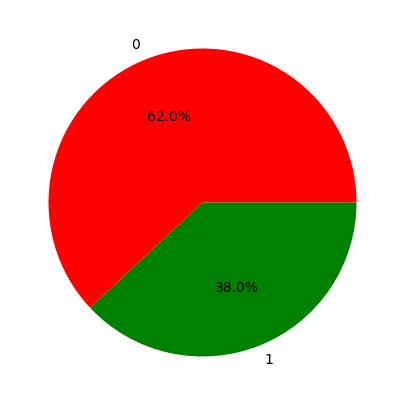

In [30]:
plt.figure(figsize=(5,5))
plt.pie(counts, labels=['0','1'], colors=['red','green'], autopct='%1.1f%%')
plt.show()

In [31]:
values, counts = np.unique(y_train, return_counts=True)

In [32]:
values, counts

(array([0., 1.]), array([10490,  6513]))

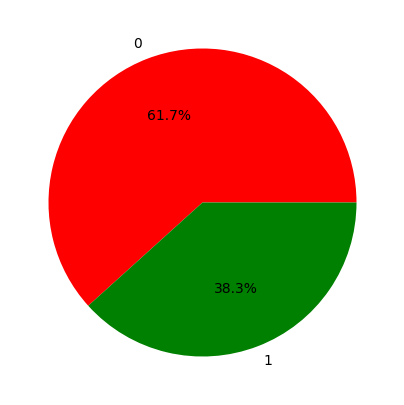

In [33]:
plt.figure(figsize=(5,5))
plt.pie(counts, labels=['0','1'], colors=['red','green'], autopct='%1.1f%%')
plt.show()

In [34]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

In [35]:
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [36]:
x_train.shape

(17003, 3000, 1)

In [55]:
import keras
from keras import models
from keras import layers

model = models.Sequential()

model.add(layers.Conv1D(64, 32, input_shape=(x_train.shape[1], x_train.shape[2]), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=4, strides=2, padding="same"))

model.add(layers.Conv1D(48, 32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=3, strides=2, padding="same"))

model.add(layers.Conv1D(48, 24, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Conv1D(32, 16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(16, activation='relu'))
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 2969, 64)       │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 2969, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 1485, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 1454, 48)       │        98,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 1454, 48)       │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 727, 48)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 704, 48)        │        55,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 704, 48)        │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 352, 48)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 337, 32)        │        24,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 337, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 169, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │       346,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529,985 (2.02 MB)

 Trainable params: 529,601 (2.02 MB)

 Non-trainable params: 384 (1.50 KB)

None


In [56]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [57]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 20, batch_size = 512)


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 467ms/step - accuracy: 0.5939 - loss: 0.7713 - val_accuracy: 0.5145 - val_loss: 0.6948
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.7890 - loss: 0.4244 - val_accuracy: 0.6200 - val_loss: 0.6802
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.8279 - loss: 0.3595 - val_accuracy: 0.6200 - val_loss: 0.7305
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.8295 - loss: 0.3489 - val_accuracy: 0.6199 - val_loss: 0.7893
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.8461 - loss: 0.3228 - val_accuracy: 0.6200 - val_loss: 0.8070
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.8433 - loss: 0.3228 - val_accuracy: 0.6198 - val_loss: 0.9337
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.8652 - loss: 0.2921 - val_accuracy: 0.6253 - val_loss: 0.7731
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.8767 - loss: 0.2716 - val_accu